# Latency prediction 

<font color='gray'> Data travelling through fiber optic cables controls bread and butter of all data scientists. Starting from source, this data does not arrive at the destination instantly. This delay, also called latency, is controled by speed of light in optical fiber i.e. ~ 2/3 times speed of light. Thus, we have  </font>

\begin{equation}
\textrm{latency} = \frac{\textrm{distance}}{\textrm{speed of light in optical fiber}}
\end{equation}


<font color='gray'> This is an interesting observation. It tells us if measured latency differs too much from the predicted latency above, something suspecious is going on. Clearly, there are many reasons for measured latency to differ from the prediction, e.g. instrumental noise. </font>

<font color='gray'> Our aim is to develop a model that detects these suspecious events and flag them. What follows below is a starting point for your python code along with helpful questions which will allow you to solve this problem. </font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Constants
C = 3e8  # speed of light in vacuum (m/s)
FIBER_SPEED = 2e8  # ~2/3 speed of light in optical fiber

<font color='gray'> You have been given simulated data that contains measured latency, which includes potetial anomalies and instrumental noise. The anomalies are labelled in the data. Following is the visualisation of the data.</font>

<font color='gray'> For your interest, we also have access to the true geographical distance between the two cities, the actual length of fiber, and the minimum latency as predicted using above equation given the length of the fiber.</font>


   Unnamed: 0    source destination  geo_distance_km  fiber_distance_km  \
0           0  New York      London      5570.222180        7517.969653   
1           1  New York      London      5570.222180        7517.969653   
2           2  New York       Tokyo     10848.807998       14449.421254   
3           3  New York       Tokyo     10848.807998       14449.421254   
4           4  New York      Sydney     15988.755507       20034.751042   

   min_latency_ms  measured_latency_ms  noise_ms  is_anomaly  
0       37.589848            37.313320 -0.276529           0  
1       37.589848            35.366088 -2.223760           0  
2       72.247106            75.405532  3.158426           0  
3       72.247106            73.781976  1.534869           0  
4      100.173755           101.258875  1.085120           0  


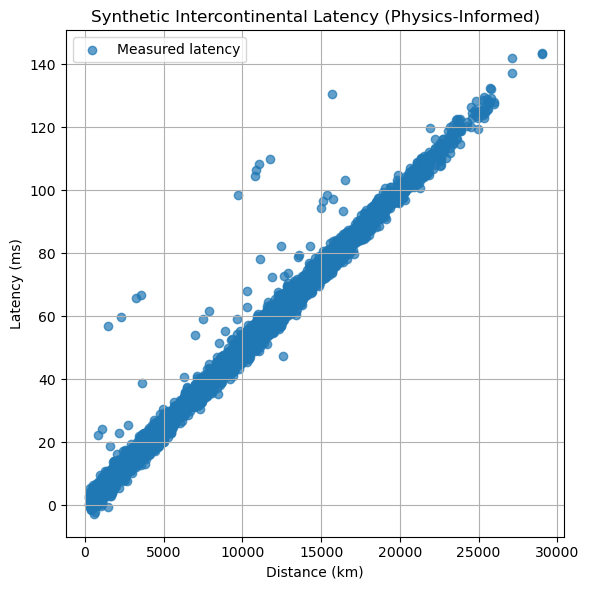

In [2]:
df = pd.read_csv('../data/latency_simulated_data_w_ground_truth.dat')
print(df.head())
# Plot
plt.figure(figsize=(6, 6))
plt.scatter(df['fiber_distance_km'], df['measured_latency_ms'], label='Measured latency', alpha=0.7)
plt.xlabel('Distance (km)')
plt.ylabel('Latency (ms)')
plt.title('Synthetic Intercontinental Latency (Physics-Informed)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# Define reusable methods to eliminate redundancy

def detect_anomalies(residuals, anomaly_threshold=2):
    """
    Detect anomalies using z-score method.
    
    Args:
        residuals: Array of residual values
        anomaly_threshold: Z-score threshold for anomaly detection
    
    Returns:
        tuple: (centered_residuals, z_score, anomalies_detected)
    """
    centered_residuals = residuals - np.mean(residuals)
    std = np.std(centered_residuals)
    z_score = centered_residuals / std
    anomalies_detected = np.abs(z_score) > anomaly_threshold
    
    print(f"Detected {np.sum(anomalies_detected)} out of {len(residuals)} samples")
    print(f"True anomalies {np.sum(df['is_anomaly'].tolist())}")
    
    return centered_residuals, z_score, anomalies_detected

In [4]:
def plot_residual_histogram(centered_residuals, anomaly_threshold=2):
    """
    Plot histogram of residuals with anomaly regions highlighted.
    
    Args:
        centered_residuals: Array of centered residual values
        anomaly_threshold: Z-score threshold for anomaly detection
    """
    std = np.std(centered_residuals)
    
    plt.figure(figsize=(6, 6))
    n, bins, patches = plt.hist(centered_residuals, density=True, bins=50, 
                               color='lightgray', edgecolor='black', label='Residuals')

    # Shade regions beyond ±2σ
    for i in range(len(bins)-1):
        if bins[i] < -anomaly_threshold*std or bins[i+1] > anomaly_threshold*std:
            patches[i].set_facecolor('red')

    # Mark ±2σ lines
    plt.axvline(-2*std, color='red', linestyle='--', linewidth=1)
    plt.axvline(2*std, color='red', linestyle='--', linewidth=1)

    # Labels and legend
    plt.xlabel('Centered Residual (ms)')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution with ±2σ Anomaly Regions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
def categorize_predictions(anomalies_detected, true_labels):
    """
    Categorize predictions into true positives, false positives, and false negatives.
    
    Args:
        anomalies_detected: Boolean array of detected anomalies
        true_labels: Boolean array of true anomaly labels
    
    Returns:
        tuple: (true_positives, false_positives, false_negatives)
    """
    true_positives = anomalies_detected & true_labels
    false_positives = anomalies_detected & ~true_labels
    false_negatives = ~anomalies_detected & true_labels
    
    return true_positives, false_positives, false_negatives

In [6]:
def plot_anomaly_detection_results(distance_feature, residuals, true_positives, false_positives, false_negatives):
    """
    Plot anomaly detection results showing true positives, false positives, and false negatives.
    
    Args:
        distance_feature: Array of distance values
        residuals: Array of residual values
        true_positives: Boolean array of true positives
        false_positives: Boolean array of false positives
        false_negatives: Boolean array of false negatives
    """
    plt.figure(figsize=(6, 6))

    # All residuals (light gray)
    plt.scatter(distance_feature, residuals, color='lightgray', label="All data", s=20)

    # True Positives: correctly detected anomalies
    plt.scatter(distance_feature[true_positives], residuals[true_positives],
                color='green', label="True Positives", s=50, marker='o')

    # False Positives: flagged but not real anomalies
    plt.scatter(distance_feature[false_positives], residuals[false_positives],
                color='orange', label="False Positives", s=50, marker='x')

    # False Negatives: real anomalies not detected
    plt.scatter(distance_feature[false_negatives], residuals[false_negatives],
                color='red', label="False Negatives", s=50, marker='^')

    plt.xlabel("Distance (km)")
    plt.ylabel("Residual (ms)")
    plt.title("Detected vs True Anomalies")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
def evaluate_thresholds(z_score, true_labels, thresholds=None):
    """
    Evaluate different threshold values and find optimal threshold based on F1 score.
    
    Args:
        z_score: Array of z-score values
        true_labels: Boolean array of true anomaly labels
        thresholds: Array of threshold values to evaluate (default: np.linspace(0.5, 4.0, 100))
    
    Returns:
        dict: Dictionary containing evaluation results and optimal threshold info
    """
    if thresholds is None:
        thresholds = np.linspace(0.5, 4.0, 100)
    
    precision_list = []
    recall_list = []
    f1_list = []
    confusion_matrices = []

    for thresh in thresholds:
        predicted = np.abs(z_score) > thresh

        TP = np.sum(predicted & true_labels)
        FP = np.sum(predicted & ~true_labels)
        FN = np.sum(~predicted & true_labels)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        confusion_matrices.append((TP, FP, FN))

    # Find optimal threshold
    best_index = np.argmax(f1_list)
    best_threshold = thresholds[best_index]
    best_f1 = f1_list[best_index]
    best_precision = precision_list[best_index]
    best_recall = recall_list[best_index]
    TP_best, FP_best, FN_best = confusion_matrices[best_index]

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(thresholds, precision_list, label='Precision', color='green')
    plt.plot(thresholds, recall_list, label='Recall', color='orange')
    plt.plot(thresholds, f1_list, label='F1 Score', color='blue')
    plt.axvline(x=1.8, color='red', linestyle='--', label='Default Threshold (1.8)')
    plt.axvline(x=best_threshold, color='purple', linestyle=':', label=f'Best F1 @ {best_threshold:.2f}')

    plt.xlabel("Anomaly Threshold (z-score)")
    plt.ylabel("Metric Value")
    plt.title("Precision, Recall, and F1 Score vs. Threshold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print results
    print(f"\n Best Threshold: {best_threshold:.2f}")
    print(f"Precision: {best_precision:.3f}")
    print(f"Recall:    {best_recall:.3f}")
    print(f"F1 Score:  {best_f1:.3f}")

    print("\n Confusion Matrix at Best Threshold:")
    print(f"True Positives (TP): {TP_best}")
    print(f"False Positives (FP): {FP_best}")
    print(f"False Negatives (FN): {FN_best}")
    print(f"True Negatives (TN): {len(true_labels) - TP_best - FP_best - FN_best}")
    
    return {
        'thresholds': thresholds,
        'precision_list': precision_list,
        'recall_list': recall_list,
        'f1_list': f1_list,
        'best_threshold': best_threshold,
        'best_f1': best_f1,
        'best_precision': best_precision,
        'best_recall': best_recall,
        'confusion_matrix': (TP_best, FP_best, FN_best)
    }

In [8]:
def run_anomaly_analysis(residuals, distance_feature, true_labels, title_suffix="", anomaly_threshold=2):
    """
    Run complete anomaly analysis pipeline.
    
    Args:
        residuals: Array of residual values
        distance_feature: Array of distance values for plotting
        true_labels: Boolean array of true anomaly labels
        title_suffix: String to append to plot titles
        anomaly_threshold: Z-score threshold for anomaly detection
    
    Returns:
        dict: Dictionary containing all analysis results
    """
    print(f"\n{'='*50}")
    print(f"Anomaly Analysis{title_suffix}")
    print(f"{'='*50}")
    
    # Detect anomalies
    centered_residuals, z_score, anomalies_detected = detect_anomalies(residuals, anomaly_threshold)
    
    # Plot histogram
    plot_residual_histogram(centered_residuals, anomaly_threshold)
    
    # Categorize predictions
    true_positives, false_positives, false_negatives = categorize_predictions(anomalies_detected, true_labels)
    
    # Plot results
    plot_anomaly_detection_results(distance_feature, residuals, true_positives, false_positives, false_negatives)
    
    # Evaluate thresholds
    evaluation_results = evaluate_thresholds(z_score, true_labels)
    
    return {
        'centered_residuals': centered_residuals,
        'z_score': z_score,
        'anomalies_detected': anomalies_detected,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'evaluation': evaluation_results
    }

# Part1: Simple linear regression

<font color='gray'> Our job here is to  try and flag the anomalies in the data. For this use linear regression followed by z-score. Make a plot visualising true anomalies, anomalies falsely flagged by your model, and anomalies correctly identified by your model i.e. ground truth, true positives and false positives. Later on, we will explore how to improve the model performance. Do you have any ideas to improve the performance? </font>


Anomaly Analysis - Part 1: Linear Regression
Detected 45 out of 4900 samples
True anomalies 54


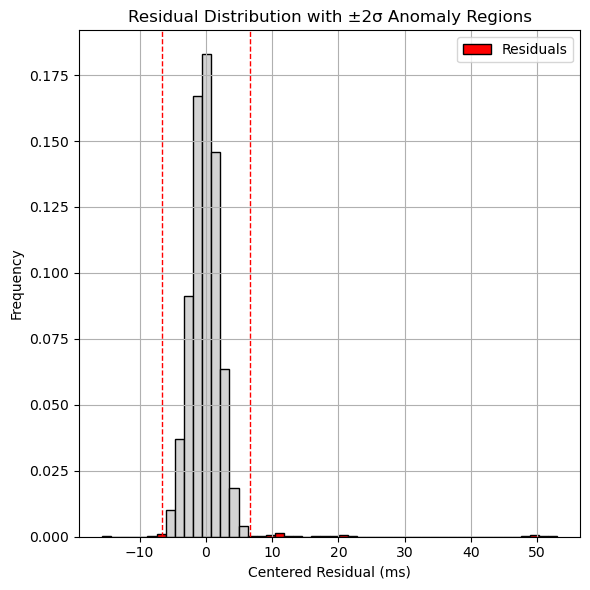

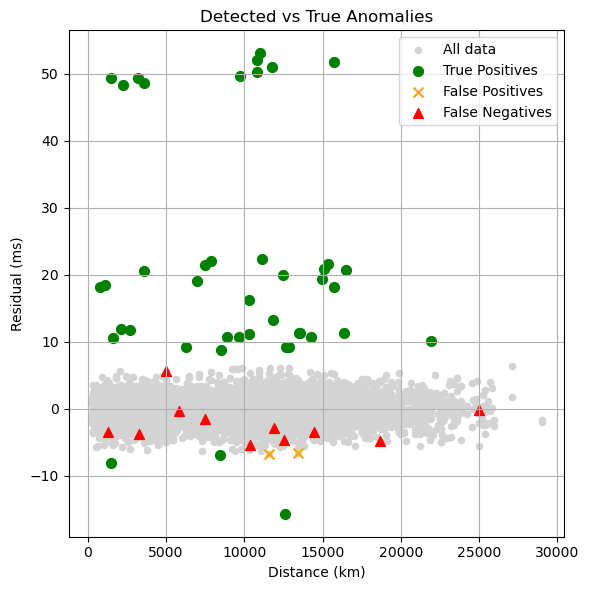

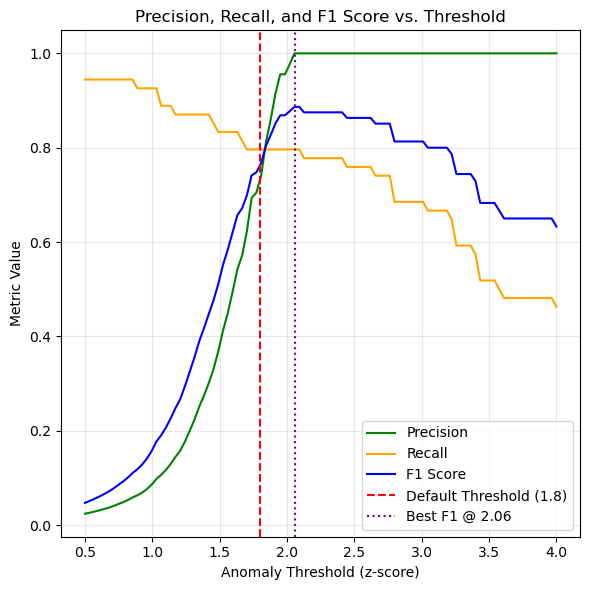


 Best Threshold: 2.06
Precision: 1.000
Recall:    0.796
F1 Score:  0.887

 Confusion Matrix at Best Threshold:
True Positives (TP): 43
False Positives (FP): 0
False Negatives (FN): 11
True Negatives (TN): 4846


In [9]:
distance_feature = np.array(df.get('fiber_distance_km')).reshape(-1, 1)
latency_feature = np.array(df.get('measured_latency_ms')).reshape(-1, 1)

model_latency = LinearRegression()
model_latency.fit(distance_feature, latency_feature)

# Calculate residuals for linear regression approach
residuals_lr = latency_feature.flatten() - model_latency.predict(distance_feature).flatten()
true_labels = df['is_anomaly'].values.astype(bool)

# Run analysis for Part 1
results_part1 = run_anomaly_analysis(residuals_lr, distance_feature, true_labels, 
                                   title_suffix=" - Part 1: Linear Regression")


 # Part2: No machine learning, just physics


Anomaly Analysis - Part 2: Physics-based
Detected 45 out of 4900 samples
True anomalies 54


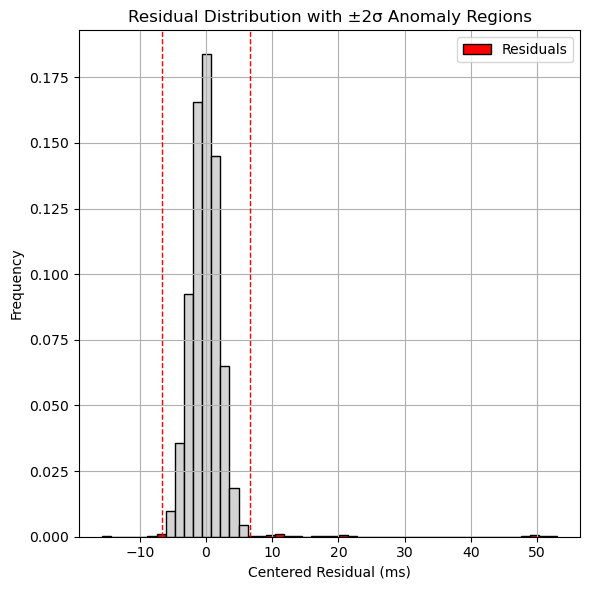

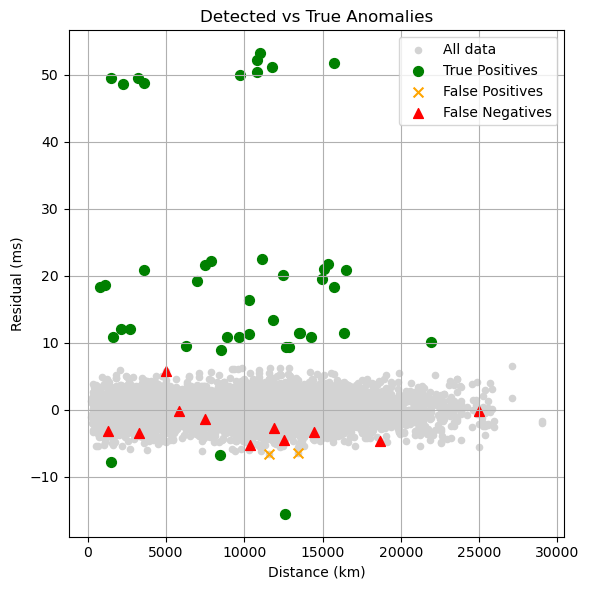

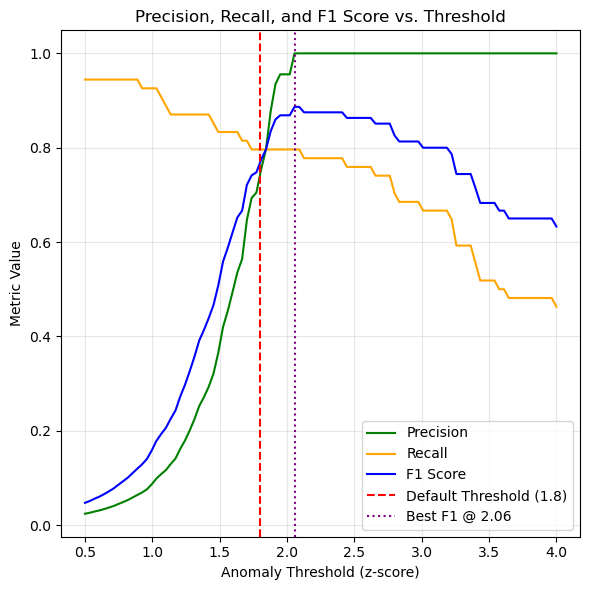


 Best Threshold: 2.06
Precision: 1.000
Recall:    0.796
F1 Score:  0.887

 Confusion Matrix at Best Threshold:
True Positives (TP): 43
False Positives (FP): 0
False Negatives (FN): 11
True Negatives (TN): 4846


In [10]:
# Calculate residuals for physics-based approach
residuals_physics = df['measured_latency_ms'] - df['min_latency_ms']

# Run analysis for Part 2
results_part2 = run_anomaly_analysis(residuals_physics, distance_feature, true_labels, 
                                   title_suffix=" - Part 2: Physics-based")